In [1]:
!pip install tigramite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 6.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
from scipy import stats
from tigramite import plotting as tp
import matplotlib.pyplot as plt
from pathlib import Path

In [6]:
# Define equation sets for different configurations
def get_equation_set(n_vars, max_lag):
    """Get equations for specified configuration"""
    if n_vars == 4:
        if max_lag == 2:
            return [
                "X4[t] = 0.25 * X1[t-2] + e4",
                "X3[t] = 0.35 * X4[t] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
        elif max_lag == 3:
            return [
                "X4[t] = 0.25 * X1[t-2] + e4",
                "X3[t] = 0.35 * X4[t] + 0.2 * X2[t-3] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
        elif max_lag == 4:
            return [
                "X4[t] = 0.25 * X1[t-4] + e4",
                "X3[t] = 0.35 * X4[t] + 0.2 * X2[t-3] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
    elif n_vars == 6:
        if max_lag == 2:
            return [
                "X6[t] = 0.85 * X5[t] + e6",
                "X5[t] = noise_extra",
                "X4[t] = 0.25 * X1[t-2] + 0.3 * X5[t-1] + e4",
                "X3[t] = 0.35 * X4[t] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
        elif max_lag == 3:
            return [
                "X6[t] = 0.85 * X5[t] + e6",
                "X5[t] = noise_extra",
                "X4[t] = 0.25 * X1[t-2] + 0.3 * X5[t-1] + e4",
                "X3[t] = 0.35 * X4[t] + 0.2 * X2[t-3] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
        elif max_lag == 4:
            return [
                "X6[t] = 0.85 * X5[t] + e6",
                "X5[t] = noise_extra",
                "X4[t] = 0.25 * X1[t-4] + 0.3 * X5[t-1] + e4",
                "X3[t] = 0.35 * X4[t] + 0.2 * X2[t-3] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
    elif n_vars == 8:
        if max_lag == 2:
            return [
                "X8[t] = 0.4 * X7[t] + e8",
                "X7[t] = 0.35 * X6[t-1] + e7",
                "X6[t] = 0.45 * X5[t] + e6",
                "X5[t] = noise_extra",
                "X4[t] = 0.25 * X1[t-2] + 0.3 * X5[t-1] + e4",
                "X3[t] = 0.35 * X4[t] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
        elif max_lag == 3:
            return [
                "X8[t] = 0.4 * X7[t] + e8",
                "X7[t] = 0.35 * X6[t-1] + e7",
                "X6[t] = 0.45 * X5[t] + e6",
                "X5[t] = noise_extra",
                "X4[t] = 0.25 * X1[t-2] + 0.3 * X5[t-1] + e4",
                "X3[t] = 0.35 * X4[t] + 0.2 * X2[t-3] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
        elif max_lag == 4:
            return [
                "X8[t] = 0.4 * X7[t] + e8",
                "X7[t] = 0.35 * X6[t-1] + e7",
                "X6[t] = 0.45 * X5[t] + e6",
                "X5[t] = noise_extra",
                "X4[t] = 0.25 * X1[t-4] + 0.3 * X5[t-1] + e4",
                "X3[t] = 0.35 * X4[t] + 0.2 * X2[t-3] + e3",
                "X2[t] = 0.3 * X3[t-1] + e2",
                "X1[t] = 0.4 * X2[t] + e1"
            ]
    return []

def extract_coefficients_from_equations(equations):
    """Extract coefficients and causal relationships from equations"""
    causal_links = {}

    for eq in equations:
        if '=' in eq and not 'noise' in eq:
            # Split equation into left and right sides
            left, right = [side.strip() for side in eq.split('=')]
            target = left.split('[')[0]

            # Process each term on the right side
            terms = [term.strip() for term in right.split('+')]
            for term in terms:
                if '*' in term and 'X' in term:
                    coeff, var_part = [p.strip() for p in term.split('*')]
                    var = var_part.split('[')[0]
                    lag_part = var_part.split('[')[1].split(']')[0]

                    lag = 0 if lag_part == 't' else -int(lag_part.split('-')[1])
                    causal_links[(var, lag, target)] = float(coeff)

    return causal_links

class TimeSeriesGenerator:
    def __init__(self, error_dist='gaussian', noise_params={'scale': 0.1, 'df': 3}, random_state=None):
        self.error_dist = error_dist
        self.noise_params = noise_params
        self.random_state = random_state

    def generate_noise(self, size):
        if self.error_dist == 'gaussian':
            return np.random.normal(0, self.noise_params['scale'], size=size)
        elif self.error_dist == 't':
            return stats.t.rvs(df=self.noise_params['df'],
                             scale=self.noise_params['scale'],
                             size=size,
                             random_state=self.random_state)

    def generate_irregular_timestamps(self, n_points, total_time, min_gap=0.1):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        times = np.zeros(n_points)
        times[0] = np.random.uniform(0, min_gap)

        for i in range(1, n_points):
            gap = np.random.exponential(scale=(total_time-times[i-1])/(n_points-i))
            times[i] = times[i-1] + max(gap, min_gap)

            if times[i] > total_time:
                times = times * (total_time / times[i])

        return times

    def find_nearest_lag_idx(self, timestamps, current_idx, lag_time):
        target_time = timestamps[current_idx] - lag_time
        past_timestamps = timestamps[:current_idx]
        if len(past_timestamps) == 0:
            return 0
        return (np.abs(past_timestamps - target_time)).argmin()


    def generate_equations(self, t, X, lag_indices, n_vars, max_lag):
            """Execute equations based on configurations"""
            noise = self.generate_noise(n_vars)
            equations = get_equation_set(n_vars, max_lag)
            causal_links = extract_coefficients_from_equations(equations)

            # Generate the values based on causal relationships
            if n_vars >= 4:  # Process base system (4 variables)
                # Handle exogenous and noise terms first
                for i in range(n_vars):
                    var_name = f'X{i+1}'
                    if var_name not in [link[2] for link in causal_links.keys()]:
                        X[t, i] = noise[i]

                # Process equations in order of dependencies
                for i in range(n_vars-1, -1, -1):  # Process from highest to lowest numbered variable
                    var_name = f'X{i+1}'
                    value = 0

                    # Add causal influences
                    for (source, lag, target), coef in causal_links.items():
                        if target == var_name:
                            source_idx = int(source[1:]) - 1
                            if lag == 0:
                                value += coef * X[t, source_idx]
                            else:
                                lag_idx = lag_indices[abs(lag)-1]
                                value += coef * X[lag_idx, source_idx]

                    # Add noise term if this is not an exogenous variable
                    if value != 0:  # If variable has any causal influences
                        X[t, i] = value + noise[i]

    def generate_multivariate_ts(self, n_points, n_vars, max_lag, total_time=100, min_gap=0.1):
        """Generate multivariate time series with irregular timestamps"""
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Initialize arrays
        X = np.zeros((n_points, n_vars))

        # Generate irregular timestamps
        timestamps = self.generate_irregular_timestamps(n_points, total_time, min_gap)

        # Initialize first steps with noise
        for i in range(max_lag):
            X[i] = self.generate_noise(n_vars)

        # Generate time series
        for t in range(max_lag, n_points):
            # Find appropriate lag indices using timestamps
            mean_diff = np.mean(np.diff(timestamps))
            lag_indices = [self.find_nearest_lag_idx(timestamps, t, i * mean_diff)
                         for i in range(1, max_lag + 1)]

            # Apply equations
            self.generate_equations(t, X, lag_indices, n_vars, max_lag)

        # Create DataFrame
        columns = [f'X{i+1}' for i in range(n_vars)]
        df = pd.DataFrame(X, columns=columns)
        df['time'] = timestamps

        return df

def create_causal_graph(n_vars, max_lag):
    """Create causal graph based on equations"""
    # Get equations and extract causal links
    equations = get_equation_set(n_vars, max_lag)
    true_links = extract_coefficients_from_equations(equations)

    # Create variable names
    var_names = [f'X{i+1}' for i in range(n_vars)]

    # Initialize matrices
    val_matrix = np.zeros((n_vars, n_vars, max_lag + 1))
    graph_matrix = np.zeros((n_vars, n_vars, max_lag + 1), dtype='bool')

    # Fill matrices based on true links
    for (source, lag, target), weight in true_links.items():
        source_idx = var_names.index(source)
        target_idx = var_names.index(target)
        lag_idx = abs(lag)

        if lag == 0:
            val_matrix[source_idx, target_idx, lag_idx] = weight
            val_matrix[target_idx, source_idx, lag_idx] = weight
            graph_matrix[source_idx, target_idx, lag_idx] = True
        else:
            val_matrix[source_idx, target_idx, lag_idx] = weight
            graph_matrix[source_idx, target_idx, lag_idx] = True

    return true_links, val_matrix, graph_matrix, var_names

def save_dataset_and_graph(df, n_vars, max_lag, sample_size, error_dist, output_dir="output"):
    """Save dataset and create causal graph"""
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Save dataset
    filename = f'{output_dir}/multivariate_ts_n{sample_size}_vars{n_vars}_lag{max_lag}_{error_dist}.csv'
    df.to_csv(filename, index=False)

    # Create and save causal graph
    true_links, val_matrix, graph_matrix, var_names = create_causal_graph(n_vars, max_lag)

    plt.figure(figsize=(10, 10))
    tp.plot_time_series_graph(
        val_matrix=val_matrix,
        graph=graph_matrix,
        var_names=var_names,
        link_colorbar_label='Causal Effect Strength',
        node_size=0.15
    )
    plt.title(f'True Causal Graph (n={sample_size}, vars={n_vars}, lag={max_lag})')
    plt.savefig(f'{output_dir}/causal_graph_n{sample_size}_vars{n_vars}_lag{max_lag}_{error_dist}.png')
    plt.close()

    # Save causal structure description
    with open(f'{output_dir}/causal_structure_vars{n_vars}_lag{max_lag}.txt', 'w') as f:
        f.write("True Causal Structure:\n")
        f.write("Format: (source, lag, target) => weight\n")
        for link, weight in true_links.items():
            f.write(f"{link} => {weight}\n")

def generate_and_save_all_combinations():
    """Generate and save datasets for all combinations"""
    sample_sizes = [500, 1000, 3000, 5000]
    n_vars_list = [4, 6, 8]
    max_lags = [2, 3, 4]
    error_dists = ['gaussian', 't']

    for n in sample_sizes:
        for vars in n_vars_list:
            for lag in max_lags:
                for dist in error_dists:
                    print(f"\nGenerating dataset: n={n}, vars={vars}, lag={lag}, dist={dist}")

                    # Generate dataset
                    noise_params = {'scale': 0.1, 'df': 3} if dist == 't' else {'scale': 0.1}
                    generator = TimeSeriesGenerator(error_dist=dist,
                                                 noise_params=noise_params,
                                                 random_state=42)

                    df = generator.generate_multivariate_ts(
                        n_points=n,
                        n_vars=vars,
                        max_lag=lag
                    )

                    # Save dataset and graph
                    save_dataset_and_graph(df, vars, lag, n, dist)

                    print(f"Dataset and causal graph saved successfully")

if __name__ == "__main__":
    generate_and_save_all_combinations()


Generating dataset: n=500, vars=4, lag=2, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=4, lag=2, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=4, lag=3, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=4, lag=3, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=4, lag=4, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=4, lag=4, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=6, lag=2, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=6, lag=2, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=6, lag=3, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=500, vars=6, lag=3, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=50

/usr/local/lib/python3.11/dist-packages/tigramite/plotting.py:3203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pyplot.figure(figsize=figsize)


Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=4, lag=3, dist=gaussian


<ipython-input-6-89b419557f7a>:258: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=4, lag=3, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=4, lag=4, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=4, lag=4, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=6, lag=2, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=6, lag=2, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=6, lag=3, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=6, lag=3, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=6, lag=4, dist=gaussian
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=6, lag=4, dist=t
Dataset and causal graph saved successfully

Generating dataset: n=1000, vars=8, lag=2, dist=gaussian
Dataset and cau

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Time differences statistics:
count    999.000000
mean       0.100069
std        0.040689
min        0.084244
25%        0.084244
50%        0.084244
75%        0.093467
max        0.465209
dtype: float64


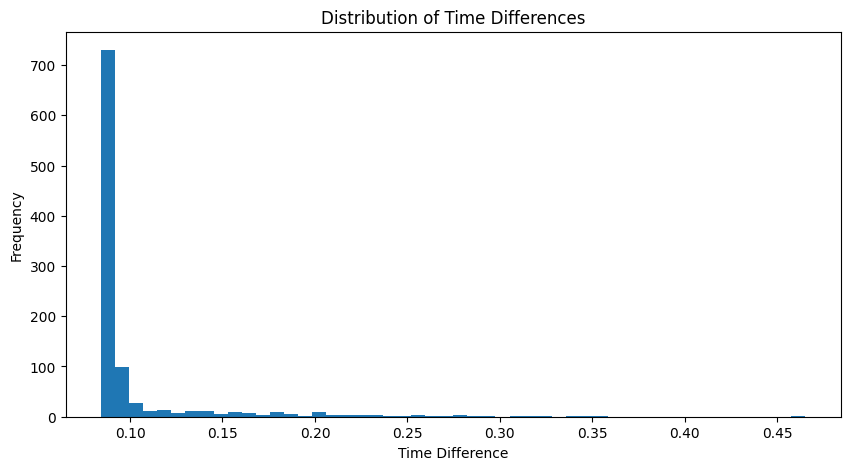

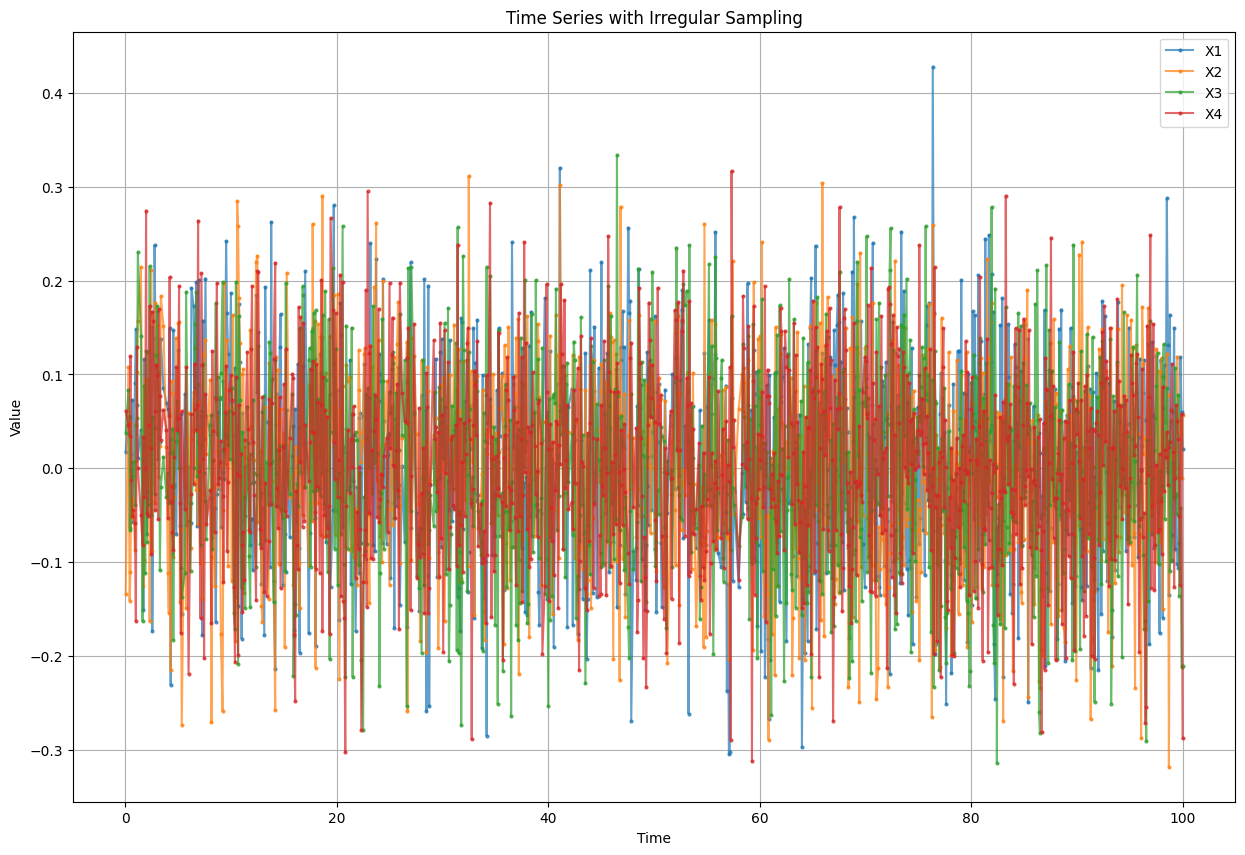

In [8]:
# First create the generator
generator = TimeSeriesGenerator(error_dist='gaussian',
                              noise_params={'scale': 0.1},
                              random_state=42)

# Then generate the data
df = generator.generate_multivariate_ts(n_points=1000, n_vars=4, max_lag=2)

# Analyze time differences
time_diffs = np.diff(df['time'])
print("Time differences statistics:")
print(pd.Series(time_diffs).describe())

# Plot distribution of time differences
plt.figure(figsize=(10, 5))
plt.hist(time_diffs, bins=50)
plt.title("Distribution of Time Differences")
plt.xlabel("Time Difference")
plt.ylabel("Frequency")
plt.show()

# Plot the time series
plt.figure(figsize=(15, 10))
for col in ['X1', 'X2', 'X3', 'X4']:
    plt.plot(df['time'], df[col], label=col, marker='o', markersize=2, linestyle='-', alpha=0.7)
plt.title("Time Series with Irregular Sampling")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Time differences statistics for t-distribution:
count    999.000000
mean       0.100069
std        0.040689
min        0.084244
25%        0.084244
50%        0.084244
75%        0.093467
max        0.465209
dtype: float64


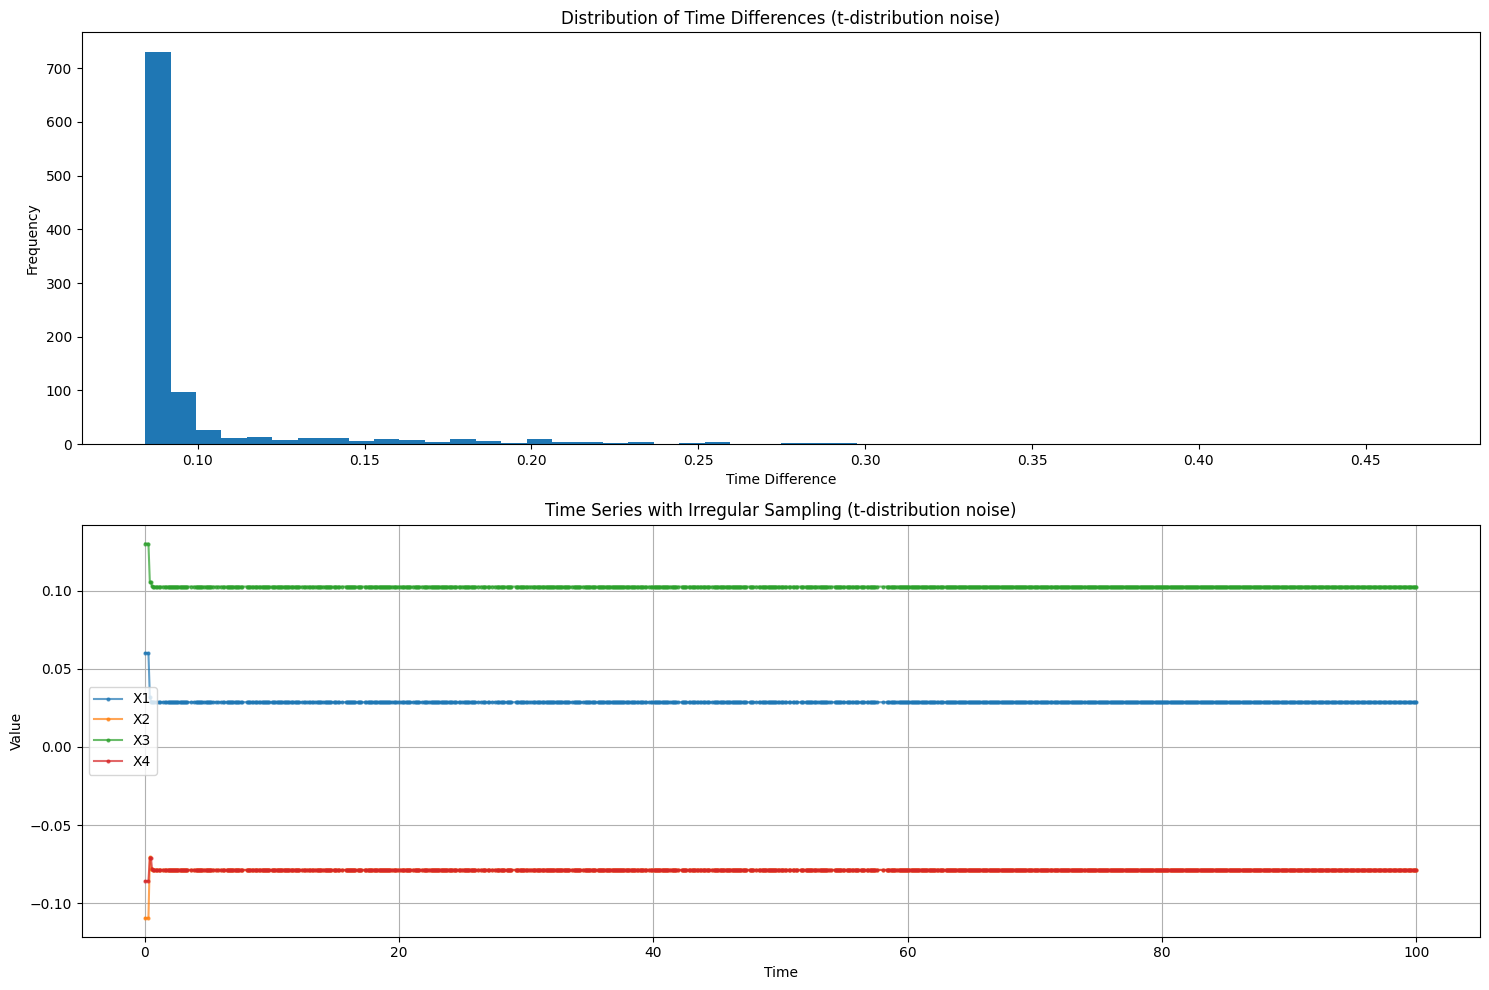

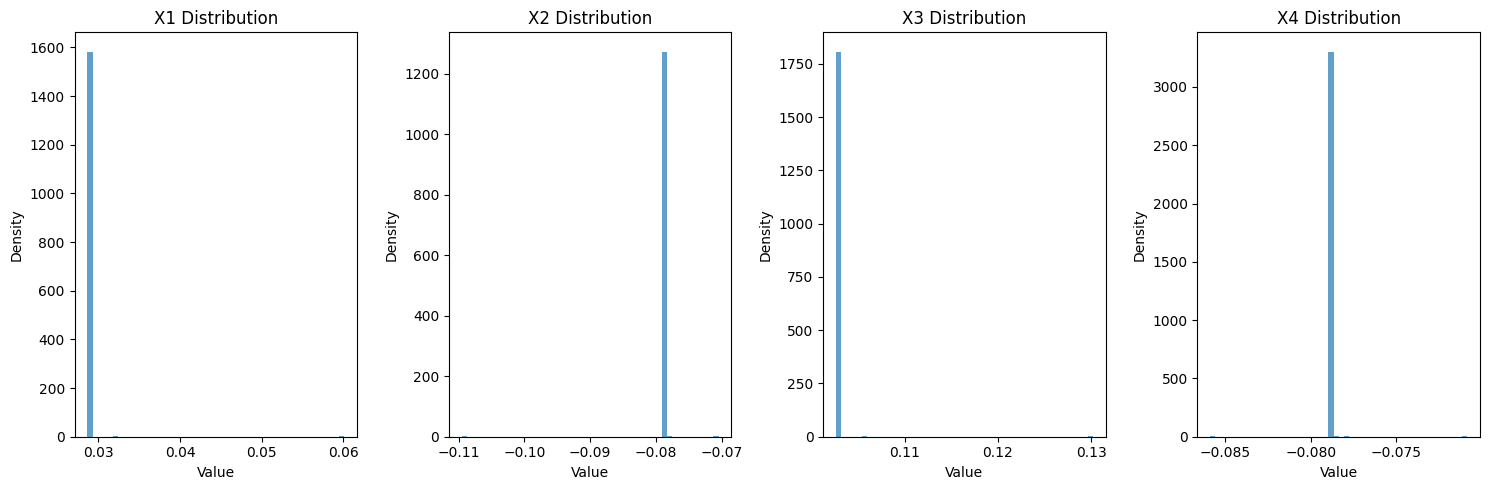


Summary statistics for variables:
                X1           X2           X3           X4
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.028705    -0.078779     0.102692    -0.078709
std       0.001411     0.001402     0.001237     0.000477
min       0.028638    -0.109517     0.102631    -0.085871
25%       0.028638    -0.078727     0.102631    -0.078711
50%       0.028638    -0.078727     0.102631    -0.078711
75%       0.028638    -0.078727     0.102631    -0.078711
max       0.060129    -0.070463     0.130180    -0.070839


In [10]:
# Create generator with Student's t distribution
generator_t = TimeSeriesGenerator(error_dist='t',
                                noise_params={'scale': 0.1, 'df': 3}, # df=3 for heavy tails
                                random_state=42)

# Generate data
df_t = generator_t.generate_multivariate_ts(n_points=1000, n_vars=4, max_lag=2)

# Analyze time differences
time_diffs = np.diff(df_t['time'])
print("Time differences statistics for t-distribution:")
print(pd.Series(time_diffs).describe())

# Create subplots for analysis
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of time differences
plt.subplot(2, 1, 1)
plt.hist(time_diffs, bins=50)
plt.title("Distribution of Time Differences (t-distribution noise)")
plt.xlabel("Time Difference")
plt.ylabel("Frequency")

# Plot 2: Time series
plt.subplot(2, 1, 2)
for col in ['X1', 'X2', 'X3', 'X4']:
    plt.plot(df_t['time'], df_t[col], label=col, marker='o', markersize=2, linestyle='-', alpha=0.7)
plt.title("Time Series with Irregular Sampling (t-distribution noise)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare distribution of values to verify heavy tails
plt.figure(figsize=(15, 5))

# Plot histograms for each variable
for i, col in enumerate(['X1', 'X2', 'X3', 'X4']):
    plt.subplot(1, 4, i+1)
    plt.hist(df_t[col], bins=50, density=True, alpha=0.7)
    plt.title(f"{col} Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

# Print summary statistics for the variables
print("\nSummary statistics for variables:")
print(df_t[['X1', 'X2', 'X3', 'X4']].describe())